## Previsão de Ações com Rendes Neurais Recorrentes

Neste exemplo é utilizado uma rede neural *Rede Neural Recorrente* para previsão dos preços de ações. Ao invés da camada *Dense*, ou juntamente com ela, utilizaremos também a camada *LSTM*. Também precisaremos fazer uma trasnformação na estrutura dos dados antes de inserir na rede neural.

In [155]:
import warnings
warnings.filterwarnings('ignore')

from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
import tensorflow 

from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [156]:
df = pd.read_csv('data/acoes/DISB34.SA.csv', parse_dates=['Date'])
df = df.dropna()
df.shape

(1335, 7)

In [157]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-01-02,175.470001,175.470001,175.470001,175.470001,175.470001,0
1,2014-01-03,175.470001,175.470001,175.470001,175.470001,175.470001,0
2,2014-01-06,175.470001,175.470001,175.470001,175.470001,175.470001,0
3,2014-01-07,180.100006,180.100006,180.100006,182.070007,182.070007,200
4,2014-01-08,180.410004,180.410004,180.410004,179.710007,179.710007,6400


In [158]:
# Selecionando dados para treino do modelo e para validação.
train = df.iloc[:df.shape[0] - 90]
test = df.iloc[df.shape[0] - 90:]

train.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1240,2018-12-26,406.429993,406.429993,403.920013,403.920013,403.920013,800
1241,2018-12-27,404.000000,404.000000,404.000000,404.000000,404.000000,100
1242,2018-12-28,416.440002,417.000000,411.209991,411.209991,411.209991,500
1243,2019-01-02,413.309998,413.309998,413.309998,413.309998,413.309998,1500
1244,2019-01-03,413.000000,413.000000,405.000000,405.000000,405.000000,300


In [159]:
test.head()

,Date,Open,High,Low,Close,Adj Close,Volume
1245,2019-01-04,410.619995,410.619995,410.619995,410.619995,410.619995,600
1246,2019-01-07,415.100006,417.380005,411.910004,411.910004,411.910004,1200
1247,2019-01-08,413.869995,413.869995,413.869995,413.869995,413.869995,300
1248,2019-01-09,414.070007,414.070007,414.070007,414.070007,414.070007,300
1249,2019-01-10,416.720001,416.720001,416.720001,416.720001,416.720001,400


In [160]:
# Número de amostras utilizadas para previsão, consideradas como memória recente.
timesteps = 1 

# Colunas que serão utlizadas na previsão do target.
# Colunas das dados anteriores a cada previsão, por isso pode-se usar o 'Close' também.
features = ['Close'] 
target = 'Close'

### Normalização dos dados

In [161]:
# Normalizador para transformar os dados do DataFrame antes da previsão.

scaler_features = MinMaxScaler((0, 1))
train_norm = pd.DataFrame(
    data= scaler_features.fit_transform(train[features]),
    columns= features
)

test_norm = pd.DataFrame(
    data= scaler_features.transform(test[features]),
    columns= features
)

train_norm.head()

,Close
0,0.017355
1,0.017355
2,0.017355
3,0.039298
4,0.031452


In [162]:
test_norm.head()

,Close
0,0.799156
1,0.803444
2,0.809961
3,0.810626
4,0.819436


In [163]:
# Normalizador que será utilizado para inverter a transformação 
# do target depois da previsão.

scaler_target = MinMaxScaler((0, 1))
scaler_target.fit( train[[target]] )

MinMaxScaler(copy=True, feature_range=(0, 1))

### Transformação dos dados para RNN

In [164]:
def transformar_dados_para_RNN(df, timesteps, colunas, target, append_before=None):
    '''Parâmetros
       -----------
        df : DataFrame que será tansformado.
        timesteps : Número de amostras que serão utilizadas. Amostras anteriores à cada previsão.
        colunas : Nomes das colunas do DataFrame que serão utilizadas.
        target : Nome do coluna que será prevista.
        append_before : DataFrame que será utilizado para extrair N amostras anteriores ao 'df'.
    '''
    
    if append_before is not None:
        df_append = append_before
        n_amostra = df_append.shape[0] - timesteps
        df = pd.concat(
            objs= (df_append.iloc[n_amostra:], df),
            axis= 0
        )
    
    previsores = []
    valores_target = []

    for i in range (timesteps, df.shape[0]):
        previsores.append( np.matrix(df.iloc[i-timesteps:i][colunas] ))
        valores_target.append( df[target].iloc[i] )
        
    return np.array(previsores), np.array(valores_target)

In [165]:
x_train, y_train = transformar_dados_para_RNN(train_norm, timesteps, features, target)
x_test, y_test = transformar_dados_para_RNN(test_norm, timesteps, features, target, append_before=train_norm)

y_test = test[target] # target não normalizado, para validação

### Criação do modelo de RNN

In [166]:
# Fixando o seed permite que o keras tenha o mesmo resultado em todas 
# as execuções, pelo menos com uma menor margem de diferença entre elas.
np.random.seed(27)
tensorflow.random.set_seed(27)

model = Sequential()

# Criando as camadas da Rede Neural
model.add(LSTM(30, activation='linear', return_sequences=True, input_shape=(timesteps, len(features)) ))
#model.add(Dropout(0.1))

model.add(LSTM(60, return_sequences=True))
#model.add(Dropout(0.3))

model.add(Dense(10))
#model.add(Dropout(0.1)

model.add(LSTM(20, return_sequences=True))

model.add(Dense(15))

model.add(LSTM(20, return_sequences=False))

model.add(Dense(1))

# Compilando o modelo com as métricas escolhidas.
model.compile(
    optimizer='rmsprop',
    loss='msle',
    metrics=['mae'],
)

In [167]:
es = EarlyStopping(monitor='loss', min_delta=1e-5, patience=15)

In [168]:
# Treinando do modelo

# epochs: número de vezes que será treinado, sobre todo o dataset.
# batch_size: Número de amostras processadas antes de atualizar os pesos. 
model.fit(
    x_train, 
    y_train,
    batch_size=100,
    epochs=150,
    callbacks=[es]
)

Epoch 1/150
1244/1244 [==============================] - 2s 2ms/sample - loss: 0.1515 - mae: 0.4643
Epoch 2/150
1244/1244 [==============================] - 0s 79us/sample - loss: 0.0612 - mae: 0.3174
Epoch 3/150
1244/1244 [==============================] - 0s 87us/sample - loss: 0.0235 - mae: 0.1776
Epoch 4/150
1244/1244 [==============================] - 0s 79us/sample - loss: 0.0196 - mae: 0.1489
Epoch 5/150
1244/1244 [==============================] - 0s 77us/sample - loss: 0.0141 - mae: 0.1217
Epoch 6/150
1244/1244 [==============================] - 0s 81us/sample - loss: 0.0069 - mae: 0.0792
Epoch 7/150
1244/1244 [==============================] - 0s 77us/sample - loss: 0.0025 - mae: 0.0498
Epoch 8/150
1244/1244 [==============================] - 0s 81us/sample - loss: 0.0012 - mae: 0.0399
Epoch 9/150
1244/1244 [==============================] - 0s 79us/sample - loss: 0.0011 - mae: 0.0420
Epoch 10/150
1244/1244 [==============================] - 0s 76us/sample - loss: 9.4407e-04 

In [169]:
pred = model.predict(x_test)

pred[:3]

array([[0.8213328],
       [0.8397228],
       [0.8439193]], dtype=float32)

### Análise da previsão

In [170]:
# Inverter a normalização
pred = scaler_target.inverse_transform(pred)

pred[:3]

array([[417.2905 ],
       [422.8218 ],
       [424.08405]], dtype=float32)

In [171]:
# Medir a precisão do modelo
# Como é a média de erro, quanto mais próximo de 0 melhor.

metrics.mean_absolute_error(y_test, pred)

10.486680790972226

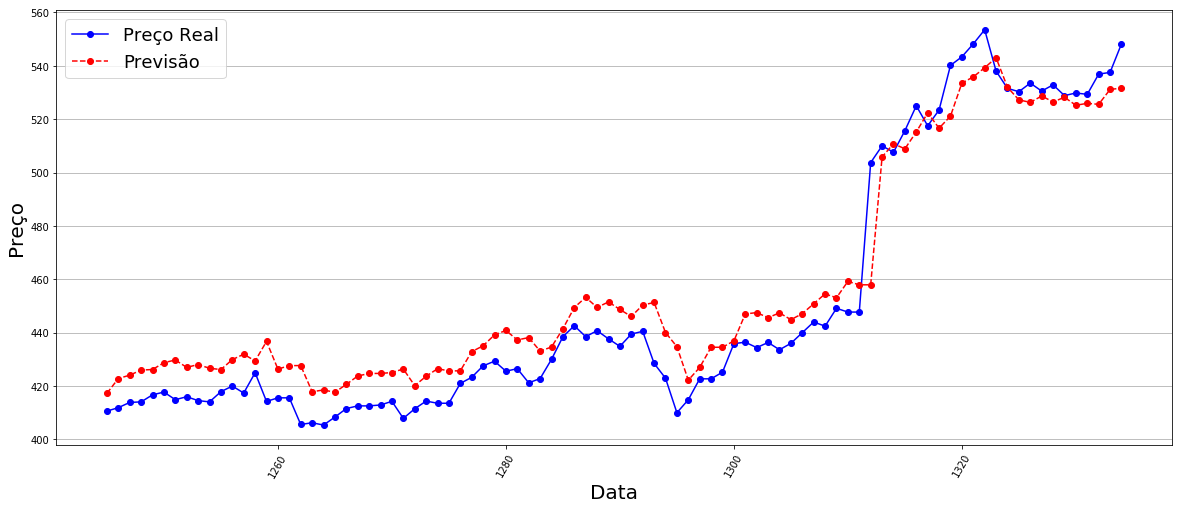

In [172]:
plt.figure(figsize=(20, 8))
plt.plot(test.index, y_test, color='blue', label='Preço Real', linestyle='-', marker='o')
plt.plot(test.index, pred, color='red', label='Previsão', linestyle='--', marker='o')

plt.legend(loc='upper left', prop={'size':18})
plt.xlabel('Data', fontdict={'size':20})
plt.ylabel('Preço', fontdict={'size':20})
plt.xticks(rotation='60')
plt.grid(axis='y')